<a href="https://colab.research.google.com/github/LuisPerdomo123/Inteligencia-Computacional/blob/main/Perceptron_Multicapa_Caso_Practico_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón Multicapa: Caso práctico III

## Dataset
Este conjunto de datos contiene los discursos de estos líderes prominentes: Benjamín Netanyahu, Jens Stoltenber, Julia Gillard, ;argaret Tacher y Nelson Mandela que también representa los nombres de las carpetas. Cada audio de la carpeta es un PCM de un segundo de duración con una velocidad de muestreo de 16 kHz codificado. Una carpeta llamada background_noise contienen audios que no son discursos, pero que se pueden encontrar en el interior alrededor del entorno del orador, por ejemplo, la audiencia riendo o aplaudiendo. Se puede mezclar con el discurso mientras se entrena.

### Referencias
https://www.kaggle.com/datasets/kongaevans/speaker-recognition-dataset

## Enunciado
El objetivo del ejercicio consiste en utilizar un perceptrón multicapa para la identificación de la persona que se encuentra hablando a partir de un audio de un segundo de duración.



## Parte I: Introducción al procesamiento de audio
En primera instancia debemos comprender como se representa digitalmente el audio y que características fundamentales tiene.

Si tienes un dataset comprimido en formato .zip que has cargado en Google Colab, puedes extraerlo y luego acceder a los archivos dentro del dataset. Aquí tienes los pasos para hacerlo:

Sube el archivo .zip a Colab: Puedes subir el archivo .zip a Colab utilizando la interfaz de usuario o mediante código.
Esto mostrará un botón de "Seleccionar archivos" que te permitirá cargar "16000_pcm_speeches.zip" desde tu sistema local.

Por ejemplo, si el archivo se llama "16000_pcm_speeches.zip" y está en tu sistema local, puedes subirlo así:

In [10]:
from google.colab import files
uploaded = files.upload()

Saving 16000_pcm_speeches.zip to 16000_pcm_speeches.zip


Extrae el archivo .zip: Una vez que hayas subido el archivo .zip, este código extraerá el contenido del archivo "dataset.zip" en el directorio "/content/dataset/" de Colab. Puedes cambiar la ruta de extracción según sea necesario.

puedes extraerlo usando el siguiente código:


In [11]:
import zipfile

with zipfile.ZipFile('16000_pcm_speeches.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

Accede a los archivos del dataset: Ahora que el dataset está descomprimido en el entorno de Colab, puedes acceder a sus archivos normalmente utilizando la ruta donde se extrajo el dataset.

Por ejemplo, si dentro del dataset hay un archivo llamado "archivo.txt", puedes acceder a él así:

In [18]:
# Definimos un conjunto de constantes con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = "/content/dataset/16000_pcm_speeches"
BENJAMIN_DATA = os.path.join(DATASET_ROOT, "Benjamin_Netanyau")
JENS_DATA = os.path.join(DATASET_ROOT, "Jens_Stoltenberg")
JULIA_DATA = os.path.join(DATASET_ROOT, "Julia_Gillard")
MARGARET_DATA = os.path.join(DATASET_ROOT, "Margaret_Tarcher")
NELSON_DATA = os.path.join(DATASET_ROOT, "Nelson_Mandela")

Para procesar el audio vamos a requerir una librería externa que debemos instalar en el contecto de nuestro Jupyter Notebook, concretamente la librería que vamos a utilizar es librosa: https://librosa.org/doc/latest/index.html

In [20]:
import IPython.display as ipd

# Define la ruta base donde se encuentran los archivos de audio

BENJAMIN_DATA = os.path.join(DATASET_ROOT, "Benjamin_Netanyau")

# Ruta del archivo de audio
audio_path = os.path.join(BENJAMIN_DATA, "22.wav")  # Ajusta la ruta según sea necesario
ipd.Audio(audio_path)

In [21]:
# Cargamos el audio mediante la libreria librosa
import librosa

wav, sr = librosa.load(os.path.join(BENJAMIN_DATA, "22.wav"))

El método load de librosa nos devuelve dos resultados:

1. Nos devuelve la onda que representa el sonido que estamos cargando en el contexto de nuestro Jupyter Notebook.
2. Nos devuelve el ratio de sampleo.

El sonido es una señal análoga, para poder hacerla digital y poderla representar numéricamente tenemos que muestrear la señal original.

El muestreo consiste en "seleccionar" un número finito de puntos de la señal original y almacenarlos en una matriz. El teorema de muestreo de Nyquist-Shannon mostró que si nuestra tasa de muestreo es lo suficientmente alta, somos capaces de capturar toda la información de la señal e incluso recuperarla completamente.

In [22]:
print(wav)

[ 0.03782462  0.07599637  0.14084502 ... -0.01175935  0.01080641
  0.01450372]


In [23]:
print(sr)

22050


La tasa de muestreo es muy importante, y la usaremos más adelante en diferentes algoritmos. Generalmente se expresa en hercios (Hz), es decir, el número de puntos (muestras) por segundo.

En nuestro ejemplo, sr = 22050 por lo que tenemos 22050 muestras por segundo, por lo tanto, podemos calcular la longitud del audio de la siguiente forma:

In [24]:
# Con la tasa de muestreo y el tamaño total de la señal se puede calcular la longitud del audio
long_audio = len(wav)/sr
print("La longitud del audio en segundos es: ", long_audio)

La longitud del audio en segundos es:  1.0


Una de las cosas interesantes que debemos hacer para obtener intuiciones sobre nuestra onda de sonido es representarla gráficamente.

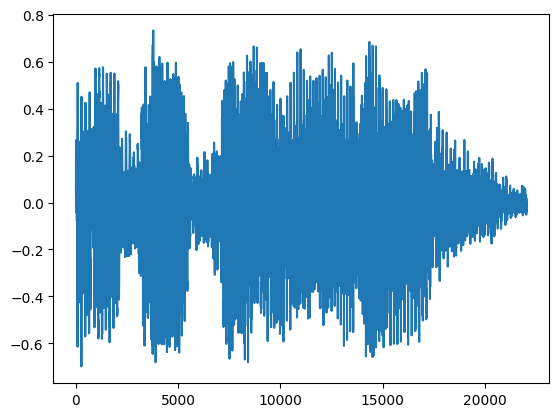

In [25]:
# Representación gráfica de la onda de sonido
from matplotlib import pyplot as plt

plt.plot(wav)
plt.show()

También podemos hacer zoom en determinados pintos específicos seleccionados durante el muestreo.

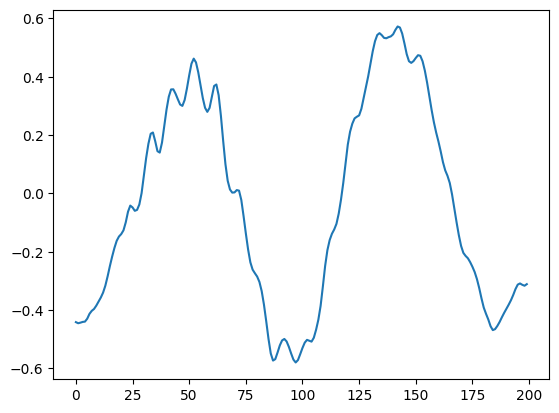

In [26]:
plt.plot(wav[1000:1200])
plt.show()

Hay algo muy importante que debemos tener en cuenta respecto a lo comentado anteriormente, en realidad, la tasa de muestreo real para el audio que hemos cargado no es 22050 Hz, librosa implicitamente remuestrea nuestros archivos para obtener este valor estándar. Para obtener la tasa de muestreo original, podemos usar el argumento **sr=flase** en el método **load**:

In [29]:
wav, sr = librosa.load(os.path.join(BENJAMIN_DATA, "22.wav"), sr=None)

In [30]:
print("Tasa de muestreo: {} Hz".format(sr))

Tasa de muestreo: 16000 Hz


### 1. Preparación del conjunto de datos

Vamos a comenzar intentando utilizar esta representación del sonido para tratar de identificar el orador al que pertence la grabación mediante el uso de un Perceptrón Multicapa.

Hay que tener en cuenta que para este tipo de casos prácticos debemos intentar buscar las voces de los oradores emitidas por diferentes altavoces o dispositivos de sonido para que la clasificación no dependa de altavoz que se esta utilizando.

In [31]:
# Definimos una función para parsear nuestro conjunto de datos
def parse_dataset(dataset_paths):
  X = []
  y = []
  for index, dataset in enumerate(dataset_paths):
    print("[+] Parsing {} data...".format(dataset))
    for fname in os.listdir(dataset):
      wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
      X.append(wav)
      y.append(index)
  return (X,y)

In [32]:
X, y = parse_dataset([BENJAMIN_DATA, JENS_DATA])

[+] Parsing /content/dataset/16000_pcm_speeches/Benjamin_Netanyau data...
[+] Parsing /content/dataset/16000_pcm_speeches/Jens_Stoltenberg data...


In [33]:
print("La longitud del conjunto de datos es: ", len(X))

La longitud del conjunto de datos es:  3000


### 2. División del conjunto de *datos*

In [34]:
# Dividimos el conjunto de datos en entrenamiento y pruebas
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [35]:
print("Longitud del subconjunto de entrenamiento: ", len(X_train))
print("Longitud del subconjunto de pruebas: ", len(X_test))

Longitud del subconjunto de entrenamiento:  2850
Longitud del subconjunto de pruebas:  150


### 3. Construcción del modelo

In [36]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver="sgd")
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [37]:
# Realizamos la predicción con el conjunto de datos de prueba
y_pred = clf.predict(X_test)

In [39]:
# Mostramos el f1_score resultante de la clasificación
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average="binary")

0.5476190476190476

In [40]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[28, 39],
       [37, 46]])

Se tiene 16000 características de entrada (tasa de muestreo) las cuales entran a cada una de las TLU de la hidden layer (10 neuronas), más los terminos byas (10), más una output layer. La exactitud en la clasificación es baja dado que se tiene un 54.76 %.

Una matriz de confusión es una tabla que se utiliza en el contexto del aprendizaje supervisado en inteligencia artificial y machine learning para evaluar el desempeño de un modelo de clasificación. Esta matriz compara las etiquetas reales de los datos de prueba con las etiquetas predichas por el modelo y muestra cuántos datos se clasificaron correctamente y cuántos se clasificaron incorrectamente.

La matriz de confusión generalmente tiene cuatro entradas, que son: verdaderos positivos (TP), falsos positivos (FP), verdaderos negativos (TN) y falsos negativos (FN). Los verdaderos positivos representan los casos en que el modelo predijo correctamente la presencia de una clase específica, los falsos positivos representan los casos en que el modelo predijo incorrectamente la presencia de una clase específica, los verdaderos negativos representan los casos en que el modelo predijo correctamente la ausencia de una clase específica y los falsos negativos representan los casos en que el modelo predijo incorrectamente la ausencia de una clase específica.

La matriz de confusión es una herramienta útil para evaluar el rendimiento de un modelo de clasificación y ajustar sus parámetros para mejorar su precisión. Además, se pueden calcular varias métricas de evaluación, como la precisión, el recall, la F1-score y la tasa de error, a partir de la información proporcionada por la matriz de confusión.

## Parte II: Otra representación del sonido

Como podemos observar en el ejercicio anterior, si utilizamos las ondas tal cual las estamos leyendo de disco, los resultados de nuestro algoritmo no son demasiado buenos. Por ello, vamos a utilizar otra representación del sonido conocida como espectrogramas.

Antes de comprender lo que es un espectrograma, debemos comprender lo que son las ondas conseno.

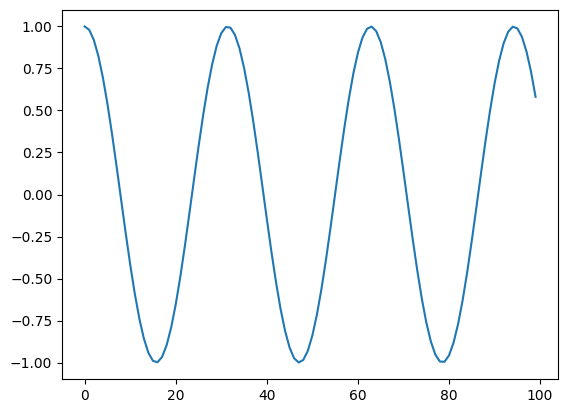

In [41]:
import numpy as np

signal = np.cos(np.arange(0, 20, 0.2))
plt.plot(signal)
plt.show()

Puede observase que se corresponden con un tipo de ondas sencillas, cuya curva describe una oscilación repetitica y suave. De manera muy sencilla podemos modificar este patrón cambiando la amplitud y frecuencia de la onda.

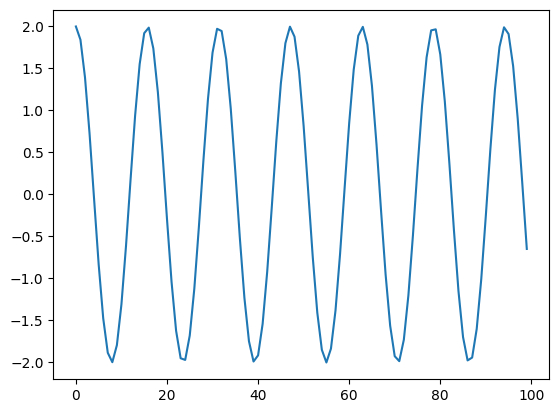

In [42]:
signal = 2*np.cos(np.arange(0, 20, 0.2)*2)
plt.plot(signal)
plt.show()

También podemos combinar dos ondas de este tipo formando ondas más complejas:

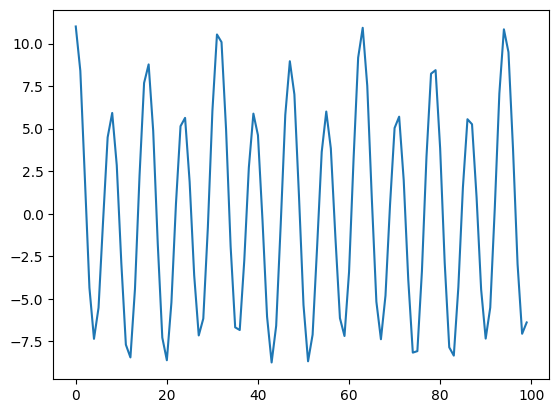

In [44]:
cos1 = np.cos(np.arange(0, 20, 0.2))
cos2 = 2*np.cos(np.arange(0, 20, 0.2)*2)
cos3 = 8*np.cos(np.arange(0, 20, 0.2)*4)

signal = cos1+cos2+cos3

plt.plot(signal)
plt.show()

Para poder proporcionar estas ondas a nuestra Red Neuronal Artificial necesitamos una representación de la misma. Podemos utililzar varias representaciones.

1. Almacenar la señal completa, que es considerablemente compleja y que hemos comprobado que no proporciona demasiado buenos resutlados.
2. Podemos almacenar únicamente las frecuencias que se utilizan en esta señal.

Representar únicamente las frecuencias de la señal es más simple y requiere mucno menos espacio en memoria. Aquí tenemos 3 frecuencias diferentes con diferentes amplitudes. La pregunta que debemos hacer es: ¿Cuáles son exactamente esas 3 frecuencias?

Necesitamos un método que, dada una onda digital, nos devuelva las frecuencias en ella. Para ello vamos a utilizar la Transformada de Fourier.

Utilizamos numpy para implementar esta función:

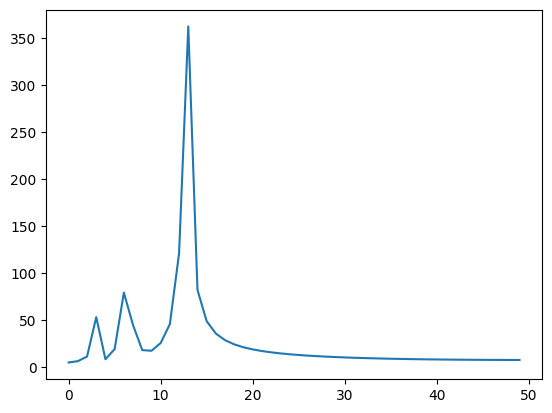

In [45]:
fft = np.fft.fft(signal)[:50]
fft = np.abs(fft)
plt.plot(fft)
plt.show()

Vemos aquí 3 frecuencias: 4, 7 y 14 bits por segundo, exactamente como construimos nuestra señal. Aquí usamos sólo la primera mitad del valor de retorno porque el resultado de la FFT es simétrico.

Resulta que cada sonido (incluso el habla humana) está compuesto de muchas de estas ondas coseno básicas en diferentes frecuencias.

Tenemos una forma de obtener frecuencias de cualquier señal de sonido, pero el habla humana no es un ruido estático, cambia con el tiempo, así que para representar correctamente el habla humana, descomponemos nuestras grabaciones en pequeñas ventanas y calculamos que frecuencias se utilizan en cada ventana.

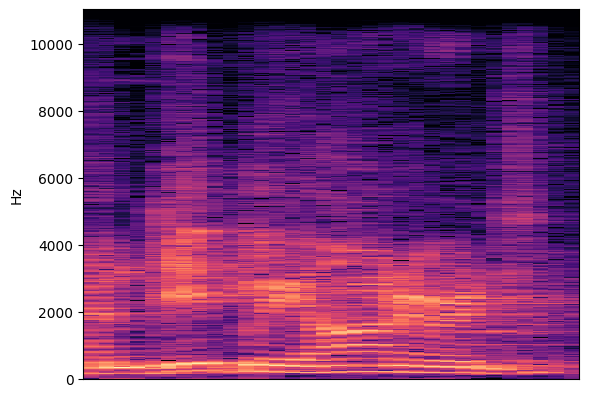

In [46]:
import librosa.display

D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.show()



*   **librosa.stft**: calcula la transformada de Fourier. Los valores de retorno son una matriz donde X son los números de ventana e Y son las frecuencias.
*   **np.abs**: Toma el absoluto del stfyt en caso de número complejo devuelve el absoluto de la parte real.
*   **librosa.amplitud_a_db**: Convierte los valores a Decibelios.
*   **librosa.display.specshow**: Muestra el espectrograma.





El espectrograma nos muestra diferentes frecuencias en diferentes partes de la grabación de la voz. Otra de las propiedades fundamentales es que a nivel de representación son muy similares a una imagen en blanco y negro.

In [47]:
# El espectrograma puede interpretarse como una imagen
D.shape

(1025, 32)

### 1. Presentación del conjunto de datos

In [48]:
# Definimos una función para parsear nuestro conjunto de datos
def parse_dataset(dataset_paths):
  X = []
  y = []
  for index, dataset in enumerate(dataset_paths):
    print("[+] Parsing {} data...".format(dataset))
    for fname in os.listdir(dataset):
      wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
      D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
      X.append(D)
      y.append(index)
  return (X, y)

In [49]:
X_prep, y_prep = parse_dataset([BENJAMIN_DATA, JENS_DATA])

[+] Parsing /content/dataset/16000_pcm_speeches/Benjamin_Netanyau data...
[+] Parsing /content/dataset/16000_pcm_speeches/Jens_Stoltenberg data...


### División del conjunto de datos

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05)

In [51]:
X_train[0].shape

(1025, 32)

### 3. Construcción del modelo

Preprocesamos los subconjuntos de daros para que puedan ser posteriormente procesados por la red neuronal artifial.

In [56]:
X_train_prep = np.array(X_train).reshape(len(X_train), 1025*32)
X_train_prep = np.array(X_train_prep).astype('float32') / 255
y_train_prep = np.array(y_train)

X_test_prep = np.array(X_test).reshape(len(X_test), 1025*32)
X_test_prep = np.array(X_test_prep).astype('float32') / 255
y_test_prep = np.array(y_test)

In [57]:
# Entrenamos un perceptron multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,),solver='sgd')
clf.fit(X_train_prep, y_train_prep)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [59]:
# Realizamos la predicción con el conjunto de datos de prueba
y_pred = clf.predict(X_test_prep)

In [60]:
# Mostramos el f1_score resultante de la clasificación
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average="binary")

0.9781021897810218